# Transfer learning

We will load a pretrained version of `EfficientNet` [1], look at its feature maps, and apply it to a different task than originally trained on.

[1] https://arxiv.org/abs/1905.11946 

In [1]:
import torch
from torchvision import models
from torchsummary import summary
import glob
from PIL import Image
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import display
import torchvision.transforms as tfms
import torch.nn as nn

from classes import IMAGENET2012_CLASSES

In [2]:
#%matplotlib notebook
%matplotlib ipympl

In [3]:
pretrained_weights = models.get_weight("EfficientNet_B6_Weights.IMAGENET1K_V1")
net = models.efficientnet_b6(weights=pretrained_weights)
net.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
            (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [4]:
image_shape = (3, 224, 224)
summary(net,image_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 56, 112, 112]           1,512
       BatchNorm2d-2         [-1, 56, 112, 112]             112
              SiLU-3         [-1, 56, 112, 112]               0
            Conv2d-4         [-1, 56, 112, 112]             504
       BatchNorm2d-5         [-1, 56, 112, 112]             112
              SiLU-6         [-1, 56, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 56, 1, 1]               0
            Conv2d-8             [-1, 14, 1, 1]             798
              SiLU-9             [-1, 14, 1, 1]               0
           Conv2d-10             [-1, 56, 1, 1]             840
          Sigmoid-11             [-1, 56, 1, 1]               0
SqueezeExcitation-12         [-1, 56, 112, 112]               0
           Conv2d-13         [-1, 32, 112, 112]           1,792
      BatchNorm2d-14         [-1, 32, 1

In [5]:
my_image = torch.rand(([5] + list(image_shape)))

In [6]:
pred = net(my_image)
pred = torch.argmax(pred,-1)
pred = pred.tolist()

In [7]:
ans = [IMAGENET2012_CLASSES[list(IMAGENET2012_CLASSES)[p]] for p in pred]

In [8]:
ans

['loudspeaker, speaker, speaker unit, loudspeaker system, speaker system',
 'matchstick',
 'loudspeaker, speaker, speaker unit, loudspeaker system, speaker system',
 'matchstick',
 'loudspeaker, speaker, speaker unit, loudspeaker system, speaker system']

Download imagenet dataset from https://huggingface.co/datasets/imagenet-1k/tree/main

In [9]:
images = glob.glob('imagenet_val/*.JPEG')
classes = [i.split('/')[-1].split('_')[-1].split('.')[0] for i in images]
labels = [IMAGENET2012_CLASSES[i] for i in classes]

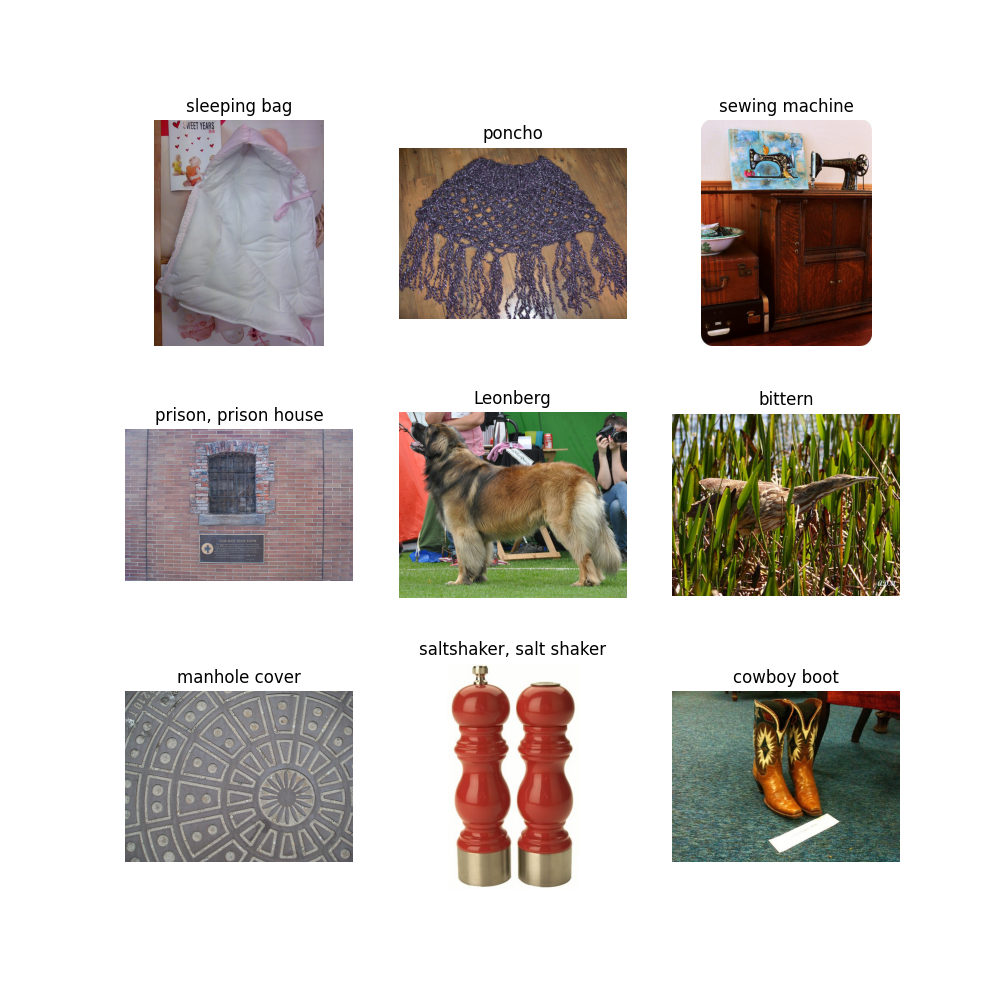

In [10]:
fig, ax = plt.subplots(3,3,figsize=(10,10))

for i in range(3):
    for j in range(3):
        index = random.randint(0,len(images)-1)
        img = Image.open(images[index])
        ax[i,j].imshow(img)
        ax[i,j].set_title(labels[index])
        ax[i,j].axis('off')

plt.show()

In [11]:
def transform_image(path=None):

    if path is None:
        images = glob.glob('imagenet_val/*.JPEG')
        image_index = random.randint(0,len(images)-1)
        path = images[image_index]

    img = Image.open(path)

    transform = tfms.Compose([
        tfms.ToTensor(),
        tfms.Resize(256),
        tfms.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225]),
    ])

    img_tensor = transform(img).unsqueeze(0)
    return img, img_tensor


In [12]:
def predict_label(path=None):

    img, img_tensor = transform_image(path)

    predictions = net(img_tensor)
    predictions = torch.softmax(predictions,dim=-1)

    topN = 3
    scores, winners  = torch.sort(predictions,descending=True)
    winners = winners.flatten().tolist()[:topN]
    scores = scores.flatten().tolist()[:topN]

    out = [f'{IMAGENET2012_CLASSES[list(IMAGENET2012_CLASSES)[winner]]}, ({score*100})%' for winner,score in zip(winners,scores)]
    txt = out[0] + '\n' + out[1] + '\n' + out[2]

    fig, ax = plt.subplots(figsize=(5,5))
    ax.imshow(img)
    ax.set_title(txt)

    return out

['home theater, home theatre, (75.55353045463562)%',
 'television, television system, (8.76447930932045)%',
 'projector, (1.409676019102335)%']

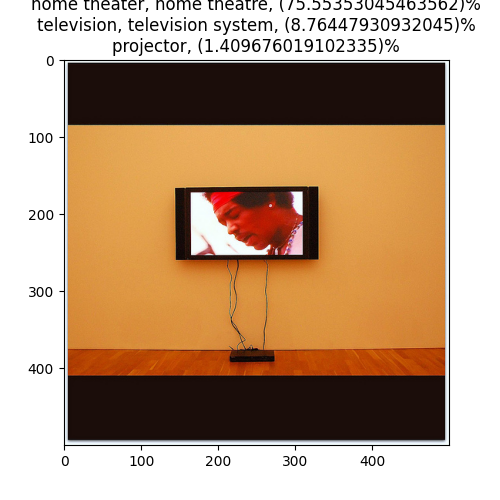

In [43]:
predict_label()

In [14]:
def get_feature_maps(net):

    maps = []

    for layer in net.children():
        layer_type = str(type(layer))
        if type(layer) == nn.Conv2d:
            maps.append(layer)
        else:
            for nest in ['Conv2dNormActivation','Sequential','MBConv']:
                if nest in layer_type:
                    for child in layer.children():
                        maps += get_feature_maps(child)
    
    return maps

In [15]:
maps = get_feature_maps(net)
wgts = [m.weight.detach() for m in maps]

In [16]:
maps[0]

Conv2d(3, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

In [17]:
wgts[0].shape

torch.Size([56, 3, 3, 3])

In [18]:
maps[0]( transform_image()[1]).shape

torch.Size([1, 56, 192, 128])

/Users/ets/miniconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


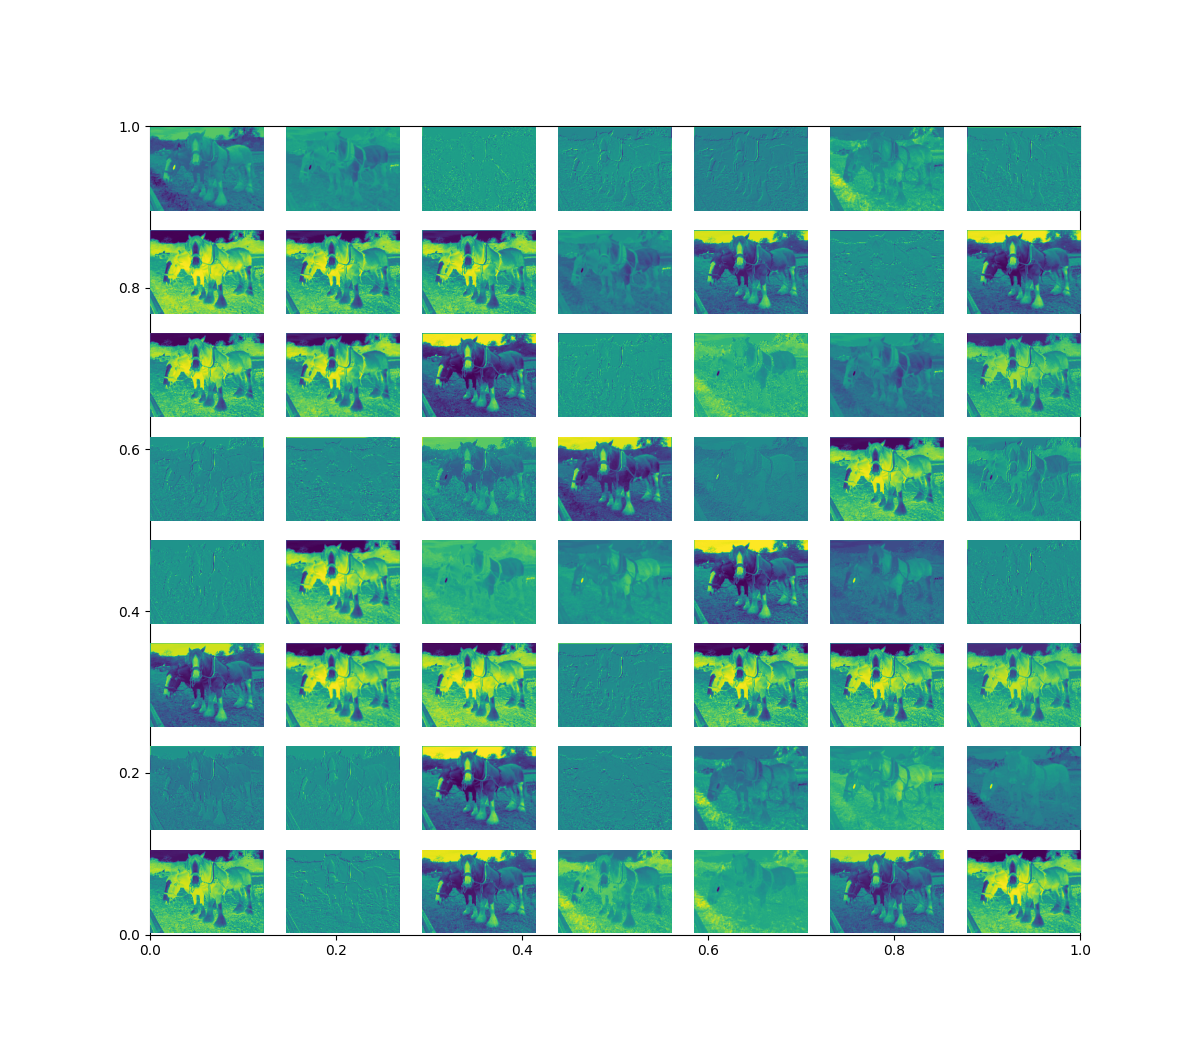

In [36]:
img, img_tensor = transform_image()
feats = maps[0](img_tensor).detach().squeeze(0)

Nrows=8
Ncols=len(feats)//Nrows

fig, ax = plt.subplots(figsize=(1.5*Nrows,1.5*Ncols))

for i, feat in enumerate(feats):
    fig.add_subplot(Nrows,Ncols,i+1)
    plt.imshow(feats[i])
    plt.axis('off')

plt.show()